Otimização da Função de Ackley

Grupo: Anderson Carneiro da Silva (acs6@cin.ufpe.br) e Lucas Thierry Chaves Muniz (ltcm@cin.ufpe.br)

In [21]:
from numpy import pi
from numpy import cos
from numpy import exp
from numpy import sqrt

Função Fitness

In [22]:
def ackley (vector, c1=20, c2=0.2, c3=2*pi):
    d = len(vector)
    sqrt_sum=0
    cos_sum=0
    for elem in vector:
        sqrt_sum += elem**2
        cos_sum += cos(c3*elem)
    
    sqrt_term = -c1 * exp(-c2*(sqrt(sqrt_sum/d)))
    cos_term = -exp(cos_sum/d)

    return sqrt_term + cos_term + c1 + exp(1)

In [23]:
print(ackley([0, 0, 0, 0]))

4.440892098500626e-16


In [24]:
import numpy as np
from abc import ABC, abstractmethod


class Individual(ABC):
    def __init__(self, value=None, init_params=None):
        if value is not None:
            self.value = value
        else:
            self.value = self._random_init(init_params)

    @abstractmethod
    def pair(self, other, pair_params):
        pass

    @abstractmethod
    def mutate(self, mutate_params):
        pass

    @abstractmethod
    def _random_init(self, init_params):
        pass


class Optimization(Individual):
    def pair(self, other, pair_params):
        return Optimization(pair_params['alpha'] * self.value + (1 - pair_params['alpha']) * other.value)

    def discreet_recomb(self, other):
        for i in range(len(self.value)):
            choice = np.random.randint(2)
            if choice==1:
                self.value[i] = other.value[i]
        return Optimization(self.value)

    def intermediate_recomb(self, other, init_params, d=0.25):
            lower_bound=init_params['lower_bound']
            upper_bound=init_params['upper_bound']
            for i in range(len(self.value)):
                spread = self.value[i]-other.value[i]
                inter_min_bound = (min(self.value[i], other.value[i]))-d*spread
                inter_max_bound = (max(self.value[i], other.value[i]))+d*spread
                if inter_min_bound < lower_bound:
                    inter_min_bound = lower_bound
                if inter_max_bound > upper_bound:
                    inter_max_bound = upper_bound
                self.value[i] = np.random.uniform(inter_min_bound, inter_max_bound)
            return Optimization(self.value)

    def mutate(self, mutate_params):
        self.value += np.random.normal(0, mutate_params['rate'], mutate_params['dim'])
        for i in range(len(self.value)):
            if self.value[i] < mutate_params['lower_bound']:
                self.value[i] = mutate_params['lower_bound']
            elif self.value[i] > mutate_params['upper_bound']:
                self.value[i] = mutate_params['upper_bound']

    def _random_init(self, init_params):
        return np.random.uniform(init_params['lower_bound'], init_params['upper_bound'], init_params['dim'])


class Population:
    def __init__(self, size, fitness, individual_class, init_params):
        self.fitness = fitness
        self.individuals = [individual_class(init_params=init_params) for _ in range(size)]
        self.individuals.sort(key=lambda x: self.fitness(x))

    def replace(self, new_individuals):
        size = len(self.individuals)
        self.individuals.extend(new_individuals)
        self.individuals.sort(key=lambda x: self.fitness(x))
        self.individuals = self.individuals[-size:]

    def replace_comma(self, new_individuals):
        size = len(self.individuals)
        new_individuals.sort(key=lambda x: self.fitness(x))
        self.individuals = new_individuals[-size:]

    def get_parents(self, n_offsprings):
        mothers = self.individuals[-2 * n_offsprings::2]
        fathers = self.individuals[-2 * n_offsprings + 1::2]

        return mothers, fathers


class Evolution:
    def __init__(self, pool_size, fitness, individual_class, n_offsprings, survival_select, \
         recomb_type, pair_params, mutate_params, init_params):
        self.pair_params = pair_params
        self.mutate_params = mutate_params
        self.pool = Population(pool_size, fitness, individual_class, init_params)
        self.n_offsprings = n_offsprings
        self.survival_select=survival_select
        self.recomb_type=recomb_type
        self.init_params=init_params

    def step(self):
        mothers, fathers = self.pool.get_parents(self.n_offsprings)
        offsprings = []

        for mother, father in zip(mothers, fathers):
            if(self.recomb_type == 'simple_pair'):
                offspring = mother.pair(father, self.pair_params)
            if(self.recomb_type == 'discreet'):
                offspring = mother.discreet_recomb(father)
            if(self.recomb_type == 'intermediate'):
                offspring = mother.intermediate_recomb(father, self.init_params)
            offspring.mutate(self.mutate_params)
            offsprings.append(offspring)

        if(self.survival_select=='comma'):
            self.pool.replace_comma(offsprings)
        elif(self.survival_select=='plus'):
            self.pool.replace(offsprings)

[-0.01292196 -0.07802456  0.21472934  0.15623591  0.11484201 -0.0377163
  0.03127721 -0.08605613 -0.13335281 -0.09346825 -0.02185654 -0.08900829
 -0.08186372 -0.00303321  0.18629886 -0.31258553  0.01103148  0.10600571
 -0.02729242  0.20797097  0.00098033 -0.01811998  0.41155799  0.05133905
  0.06494242 -0.10981522 -0.08111166  0.12273421 -0.20504228  0.03511886]
0.8010383270934223


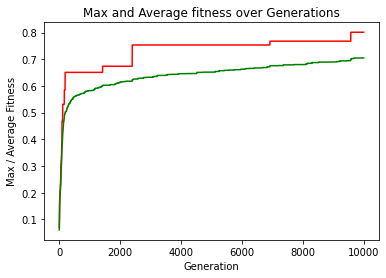

[ 0.11392268  0.00093504  0.08381431 -0.09000368  0.08090248  0.06206603
  0.00046985 -0.00340414 -0.01539483 -0.35089213  0.15381736 -0.07840544
  0.12090654  0.1948749  -0.0354608  -0.00931468  0.18900154  0.17724139
 -0.13221618 -0.22909465  0.09377559 -0.0594645  -0.18238922  0.01410732
  0.08497716  0.14209891 -0.13440885 -0.02717528  0.39750309 -0.0112299 ]
0.7547249852559614


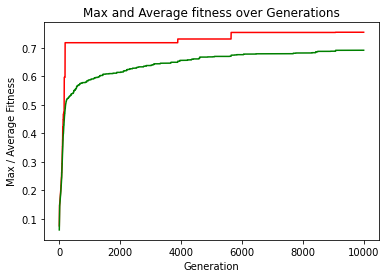

[ 0.25875403  0.12872159 -0.04062681 -0.0406931   0.21000949 -0.00141707
  0.05857651 -0.12613469 -0.10059902 -0.25156973  0.01900943  0.00035857
  0.0603646  -0.13578564 -0.04328814  0.08770997  0.05679218 -0.05481247
 -0.22220149  0.00879123 -0.05885966  0.09472448 -0.31376915  0.03262966
  0.01492529  0.12158865  0.04813066 -0.08834436  0.16149754 -0.07392524]
0.8798166094373934


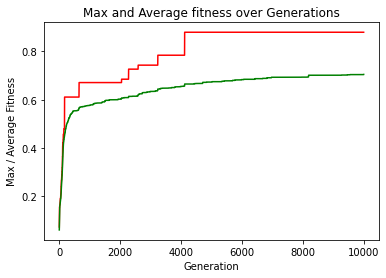

simple_pair Recombination - plus Survival - average best fitness 0.8118599739289257
Highest fitness 0.8798166094373934


In [25]:
import matplotlib.pyplot as plt

def fitness(vector):
    return 1/ackley(vector.value)


xi_min = -15
xi_max = 15
dimensions = 30
generations = 10000
tries_per_params = 3

variable_params_dict_default = {'pool_size': 30, 'fitness': fitness, 'individual_class': Optimization, \
    'n_offsprings': 15, 'survival_select': 'plus', 'recomb_type': 'intermediate'}
pair_params_dict_default = {'alpha': 0.5}
mutate_params_dict_default = {'lower_bound': xi_min, 'upper_bound': xi_max, 'rate': 0.25, 'dim': dimensions}
init_params_dict_default = {'lower_bound': xi_min, 'upper_bound': xi_max, 'dim': dimensions}

# surv_list = ['comma', 'plus']
# recomb_list = ['simple_pair', 'discreet', 'intermediate']

surv_list = ['plus']
recomb_list = ['simple_pair']

for recomb in recomb_list:
    for surv in surv_list:
        tries_fitness_list=[]
        for z in range(tries_per_params):
            variable_params_dict = variable_params_dict_default
            pair_params_dict = pair_params_dict_default
            mutate_params_dict = mutate_params_dict_default
            init_params_dict = init_params_dict_default
            variable_params_dict['survival_select'] = surv
            variable_params_dict['recomb_type'] = recomb
            evo = Evolution(
                pool_size = variable_params_dict['pool_size'], fitness = variable_params_dict['fitness'], \
                    individual_class = variable_params_dict['individual_class'], \
                        n_offsprings = variable_params_dict['n_offsprings'], \
                            survival_select = variable_params_dict['survival_select'], \
                                recomb_type = variable_params_dict['recomb_type'],
                pair_params=pair_params_dict,
                mutate_params=mutate_params_dict,
                init_params=init_params_dict
            )

            maxFitnessValues = []
            meanFitnessValues = []
            for i in range(generations):
                evo.step()
                best_individual = evo.pool.individuals[-1]
                best_fitness = fitness(best_individual)
                maxFitnessValues.append(best_fitness)
                avg = 0
                for e in evo.pool.individuals:
                    avg += fitness(e)
                meanFitnessValues.append(avg/(len(evo.pool.individuals)))
                if best_fitness > (1/0.1):
                    break

            tries_fitness_list.append(best_fitness)
            print(best_individual.value)
            print(best_fitness)

            plt.plot(maxFitnessValues, color='red')
            plt.plot(meanFitnessValues, color='green')
            plt.xlabel('Generation')
            plt.ylabel('Max / Average Fitness')
            plt.title('Max and Average fitness over Generations')

            plt.show()
        print(f'{recomb} Recombination - {surv} Survival - average best fitness {np.mean(tries_fitness_list)}')
        print(f'Highest fitness {max(tries_fitness_list)}')